# Pyroomacoustics Demo

### dependencies:  pyroomacoustics, pysoundfile, samplerate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import soundfile

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

%matplotlib inline

import librosa
import librosa.display
import samplerate

import IPython.display as ipd

from scipy import signal

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

import pandas as pd

In [2]:
def plot_spec(spec, t_audio, frame_len, fs, hop=None):
    
    if hop is None:
        hop = frame_len
        
    fig, ax = plt.subplots(figsize=(20,7))
    spec = np.swapaxes(spec, 0 ,1)
    cax = ax.imshow(spec, interpolation=None, origin='lower', aspect='auto')
    ax.set_xlabel("Time [seconds]", fontsize=30)
    ax.set_ylabel("Frequency [Hz]", fontsize=30)
    x_labels = np.arange(max(t_audio), step=0.5)
    plt.xticks(x_labels*fs//hop, x_labels, fontsize=20)
    freqs = np.arange(frame_len//2+1) / frame_len * fs
    y_labels = np.arange(max(freqs)+1, step=1000).astype(np.int)
    plt.yticks(y_labels//(fs/frame_len), y_labels, fontsize=20)
    plt.tight_layout()

## Read file and show it in spectogram 

In [3]:
file_name = '../recordings/180910_142834.wav'

In [4]:
def read_sound(file_name, time=[231, 245], channel = 0):
    data, fs = soundfile.read(file_name, stop=10)
    data, fs = soundfile.read(file_name, start=time[0]*fs, stop=time[1]*fs)
    
    data = data[:,0]
    
    return data, fs

In [5]:
data, fs = read_sound(file_name)

In [6]:
data, fs = read_sound(file_name, time=[285, 287])

In [107]:
data, fs = read_sound(file_name, time=[60, 245])

In [7]:
data.shape

(88200,)

In [8]:
def spect(data, fs, fmin=100, fmax = 1000, nfft_ratio=2, overlap_ratio=16, Gain = 35, figsize=(15, 10)):

       
    # Simple API
    ratio = fmax*2./(fs)
    nfft=int(1024./nfft_ratio)
    new_fs = int(fs*ratio)
    converter = 'sinc_best'  # or 'sinc_fastest', ...
    output_data_simple = samplerate.resample(data, ratio, converter)

    sos = signal.butter(10, fmin, 'hp', fs=new_fs, output='sos')
    output_data_simple = signal.sosfilt(sos, output_data_simple)

    X = librosa.stft(output_data_simple, n_fft=nfft, hop_length=int(nfft/(overlap_ratio*1.)))

    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=figsize)
    librosa.display.specshow(Xdb, sr=new_fs, x_axis='time', y_axis='hz', fmin=0, fmax=fmax, cmap='inferno')


    soundfile.write('test.wav', 10**(Gain/20.)*output_data_simple,samplerate=new_fs)

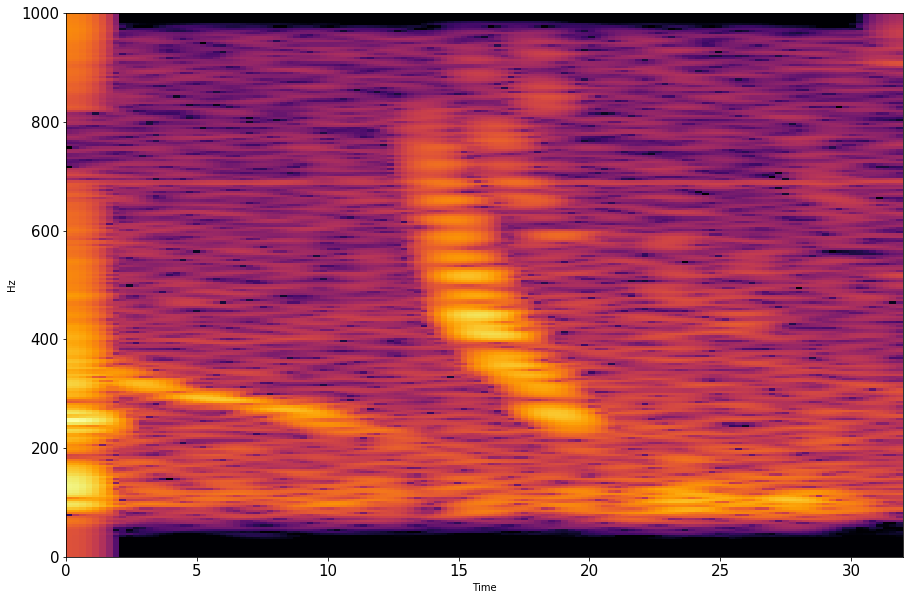

In [9]:
spect(data, fs)

## Create room 

In [61]:
scale_fact = 10000.
def sim_room(signal, fs, room_dim = [10000, 10000, 10000], r_source=[5005, 7.5, 5000],
             r_rec=np.c_[
    [5000, 5, 5000],  # mic 1
    [5000, 10, 5000],  # mic 2
    ], **kwargs):
    
    if 'max_order' in kwargs.keys():
        max_order = kwargs['max_order']
    else:
        max_order = 5
    
    if 'absorption' in kwargs.keys():
        absorption = kwargs['absorption']
    else:
        absorption = 0.5
        
    
    scale_fact = 10000.
    room_dim = np.array(room_dim)/scale_fact
    r_source = np.array(r_source)/scale_fact
    r_rec = np.array(r_rec)/scale_fact
    
    aroom = pra.ShoeBox(room_dim, fs=fs, max_order=max_order, absorption=absorption)
    aroom.add_source(r_source, signal=data)
    mic_array = pra.MicrophoneArray(r_rec, aroom.fs)
    aroom.add_microphone_array(mic_array)

    aroom.plot()
    
    aroom.compute_rir()
    aroom.simulate()
    
    out_signal = aroom.mic_array.signals
    
    # normalize to originl sound levels
    org_ENR = np.sum(signal**2)
    new_ENR = np.sum(out_signal**2, axis=1).max()
    

    return np.sqrt(org_ENR/new_ENR)*out_signal

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


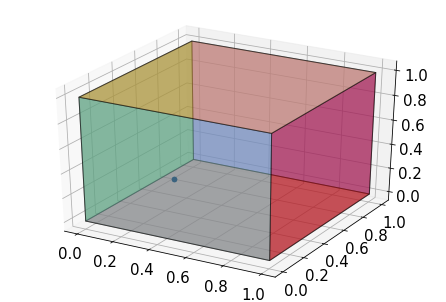

In [79]:
rec_signal = sim_room(data, fs, absorption=0.1)

In [80]:
# this is the result for each mike

rec_signal.shape

(2, 89092)

### note that aroom.mic_array.signals is normalized and not in original amplitude

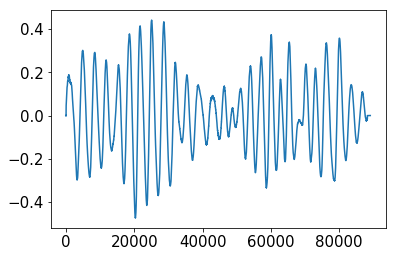

In [81]:
plt.plot(rec_signal[0,:])
plt.show()

# Add sea noise

In [158]:
def add_noise(signal_dual, SNR=0, noise_location_doc='silence_180910_142834.txt', noise_id=(0,1)):
    """ add noise to dual channal signal at two recievers
    :param SNR: SNR relative to signal[0]
    :param noise_location_doc: the txt file containing the noise locations in the file
    :param noise_id: rows to use in file to extract noise
    """
    
    sea_noise_times = pd.read_csv(noise_location_doc, sep=' ', header=None).values
    noise_data_1, _ = read_sound(file_name, sea_noise_times[0, :])
    noise_data_2, _ = read_sound(file_name, sea_noise_times[1, :])
    noise_data = np.concatenate((noise_data_1.reshape(1,-1), noise_data_2.reshape(1,-1)), axis=0)
    
    # cut signal and noise to the length of the shortest of them
    final_signal_length = min(signal_dual.shape[1], noise_data.shape[1])
    
    noise_data = noise_data[:, :final_signal_length]
    signal_dual = signal_dual[:, :final_signal_length]
    
    ENR_sig = np.sum(signal_dual**2, axis=1, keepdims=True)
    ENR_noise = np.sum(noise_data**2, axis=1, keepdims=True)
    
    total_sig_noise = np.sqrt(10**(SNR/10))*(signal_dual / np.sqrt(ENR_sig)) + (noise_data / np.sqrt(ENR_noise))
    
    return total_sig_noise / np.sqrt(np.sum(total_sig_noise**2, axis=1, keepdims=True))


In [168]:
rec_signal_noised = add_noise(rec_signal, SNR=0, noise_id=(2,3))

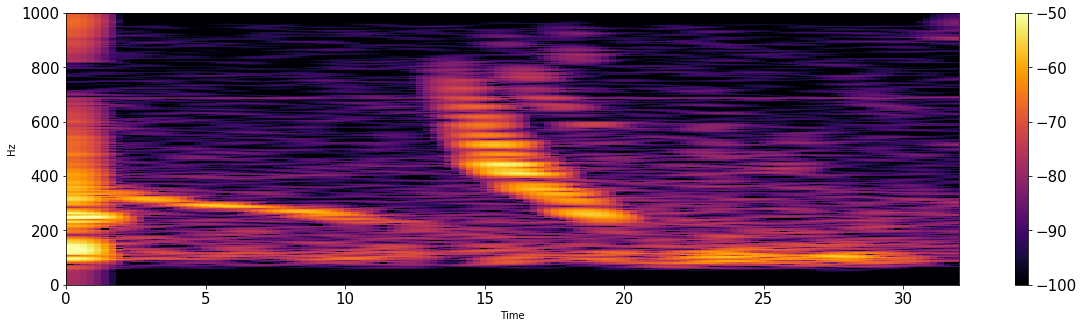

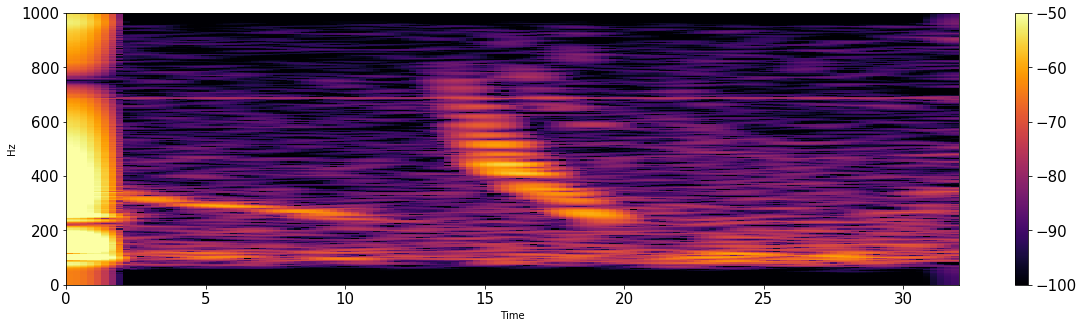

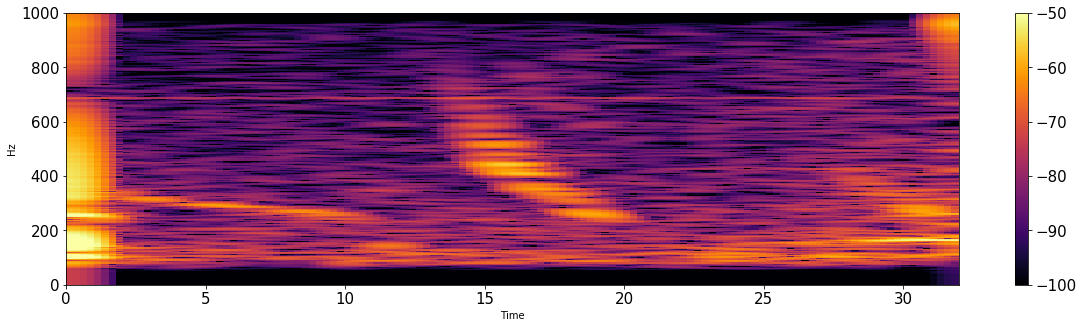

In [169]:
spect(data/np.sqrt(np.sum(data**2)), fs, figsize=[20,5])
plt.colorbar()
plt.clim((-100,-50))

spect(rec_signal_noised[0,:], fs, figsize=[20,5])
plt.colorbar()
plt.clim((-100,-50))

spect(rec_signal_noised[1,:], fs, figsize=[20,5])
plt.colorbar()
plt.clim((-100,-50))


# Music

In [170]:
algo_name = 'MUSIC'
pra.doa.algorithms.keys()

dict_keys(['SRP', 'MUSIC', 'CSSM', 'WAVES', 'TOPS', 'FRIDA'])

In [171]:
azimuth = 0

In [172]:
################################
# Compute the STFT frames needed
nfft = 1024//2
X = np.array([ 
    pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T 
    for signal in rec_signal ])


In [173]:
X.shape

(2, 257, 347)

MUSIC
  Recovered azimuth: [271.] degrees
  Error: [89.] degrees


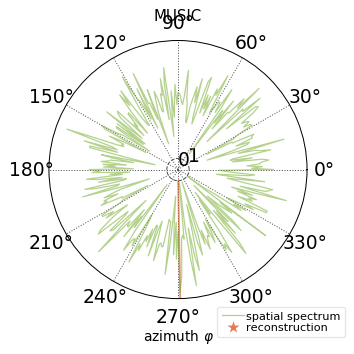

In [174]:

r_rec=np.c_[
    [5005, 5000, 9995],  # mic 1
    [5005, 5000, 9990],  # mic 2
    ]/scale_fact
doa = pra.doa.algorithms[algo_name](r_rec, fs, nfft=nfft, c=1500/scale_fact, mode='near')
doa.locate_sources(X, freq_range=[300., 600.])

doa.polar_plt_dirac()
plt.title(algo_name)

# doa.azimuth_recon contains the reconstructed location of the source
print(algo_name)
print('  Recovered azimuth:', doa.azimuth_recon / np.pi * 180., 'degrees')
print('  Error:', circ_dist(azimuth, doa.azimuth_recon) / np.pi * 180., 'degrees')

In [145]:
270+np.arctan(2.5/7.5)*180/np.pi

288.434948822922